In [2]:
import torch
import pydiffvg
import svgpathtools
import matplotlib.pyplot as plt
from utils.svgutils import loadClipassoSVG, saveClipassoSVG, renderCLipassoSVG, tensor2SVG
from utils.datasets import ClipassoDataset, canonizePaths, decanonizePaths
from torch.utils.data import DataLoader
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Test Utils Functions

In [ ]:
svgdict = loadClipassoSVG("/home/etaisella/data/256_ObjectCategories_clipasso/jesus-christ_7/119_0011_16strokes_seed0/best_iter.svg")
print(f"tensor shape: {svgdict['paths_tensor'].shape}, tensor: {svgdict['paths_tensor']}")
saveClipassoSVG("/home/etaisella/repos/svgLearner/test1.svg", svgdict["shapes"], svgdict["shape_groups"])
img = renderCLipassoSVG(svgdict["shapes"], svgdict["shape_groups"])
# save rendered image
plt.imsave("/home/etaisella/repos/svgLearner/test1.png", img.detach().cpu().numpy())

### Test Clipasso Dataset

len dataset: 1092
sample img shape: torch.Size([1, 224, 224])


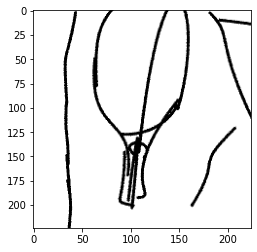

In [51]:
clipdata = ClipassoDataset("/home/etaisella/data/256_ObjectCategories_clipasso/train")
print(f"len dataset: {len(clipdata)}")
dataloader = DataLoader(clipdata, batch_size=1, shuffle=True)
dataiter = iter(dataloader)
img, paths = next(dataiter)
print(f"sample img shape: {img.shape}")
# display image
# convert image fron 1 channel grayscale to 3 channel RGB
img = 1.0 - img.repeat(1, 3, 1, 1)
plt.imshow(img.squeeze().permute(1, 2, 0).detach().cpu().numpy())

sample paths shape: torch.Size([1, 128])


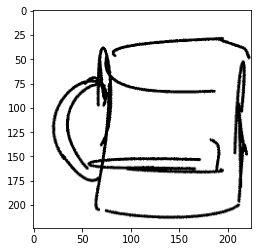

In [45]:
print(f"sample paths shape: {paths.shape}")
svgdict = tensor2SVG(paths + torch.rand_like(paths) * 15, s_width=1.5)
img = renderCLipassoSVG(svgdict["shapes"], svgdict["shape_groups"])
plt.imshow(img.squeeze().detach().cpu().numpy())

### Import SVG

In [ ]:
INPUT_SVG = '/home/etaisella/repos/CLIPasso/output_sketches/cow/cow_16strokes_seed2000_best.svg'
paths, attributes = svgpathtools.svg2paths(INPUT_SVG)
print(paths)
print(attributes)

# convert to diffVG format to create new SVG
shapes=[]
shape_groups=[]
for path in paths:
    # parse each path into 4 2D control points in a torch tensor
    path_points = []
    for segment in path:
        if isinstance(segment, svgpathtools.path.CubicBezier):
            path_points.append([segment.start.real, segment.start.imag])
            path_points.append([segment.control1.real, segment.control1.imag])
            path_points.append([segment.control2.real, segment.control2.imag])
            path_points.append([segment.end.real, segment.end.imag])
        elif isinstance(segment, svgpathtools.path.Line):
            path_points.append([segment.start.real, segment.start.imag])
            path_points.append([segment.end.real, segment.end.imag])
        else:
            raise ValueError("Unsupported path segment type")
    path_points = torch.tensor(path_points).to(device)
    diffvg_path = pydiffvg.Path(num_control_points = torch.zeros(1, dtype = torch.int32) + 2,
                                points = path_points,
                                stroke_width = torch.tensor(1.5),
                                is_closed = False)
    stroke_color = torch.tensor([0.0, 0.0, 0.0, 1.0])
    shapes.append(diffvg_path)
    path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
                                        fill_color = None,
                                        stroke_color = stroke_color)
    shape_groups.append(path_group)      

# save SVG
for i in range(len(shapes)):
    print(shape_groups[i].shape_ids[0])
    print(shapes[shape_groups[i].shape_ids[0]])

pydiffvg.save_svg('test.svg', 224, 224, shapes, shape_groups)
